In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from datetime import date
from datetime import datetime
import math
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# from process import process

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
raw_data = pd.read_csv("../demand-forecasting-in-retail/train.csv")

In [6]:
# def compute_components_theil_wage(X, m=52, h=1):
#     alpha = 0.3
#     beta = 0.1
#     gamma= 0.5
#     n = X.shape[0]
#     X.index = np.arange(n)
#     l = np.zeros(n + h)
#     b = np.zeros(n + h)
#     s = np.zeros(n + h)
#     y_hat = np.zeros(n + h)
#     l[0] = 1
#     for i in range(min(m, n)):
#         s[i] = 0
#     b[0] = 1
#     for t in range(1, n):
#         l[t] = alpha * X[t] + (1 - alpha)*(l[t-1] + b[t-1])
#         if (t >= m):
#             l[t] -= alpha * s[t-m]
#             s[t] = gamma * (X[t] - l[t]) + (1 - gamma) * s[t-m]
#         b[t] = beta * (l[t] - l[t-1]) + (1 - beta)*b[t-1]
#         y_hat[t+h] = l[t]
#         if (t - m + h >= 0):
#             y_hat[t+h] += h * b[t] * s[t-m+h]
    
#     return l, b, s, y_hat

In [7]:
import math

In [8]:
def TheilWageSmoothing(x, params, h=1):
    """
    Get predictions for timeseries using Theil-Wage model
    
    :x - time series
    :params - dict with keys: "alpha", "beta", "gamma", "season", "damp_trend"
    :h - horison
    
    Return
    :y_pred - predictions, size n + h (n - size of time series)
    :l - forecast parameter without trend and seasonality, size n
    :b - trend component, size n
    :s - seasonal component, size n
    """
    T = len(x)
    x.index = np.arange(T)
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    p = params['season']
    damp_trend = params['damp_trend']
    
    y_pred = [np.NaN]*(T+h)
    
    l = [np.NaN] * T
    l[0] = x[0]
    b = [np.NaN] * T
    b[0] = 0
    s = [np.NaN] * (T + p)
    for i in range(p):
        if i < T:
            s[i] = x[i]
        else:
            s[i] = s[i-1]
            
    sum_damp_trend = 0
    for i in range(1, h + 1):
        sum_damp_trend += damp_trend ** i

    for i in range(T):
        if not math.isnan(x[i]):
            if i < p and i > 0:
                l[i] = alpha * (x[i] - s[i]) + (1 - alpha) * (l[i-1] + b[i-1] * damp_trend)
                b[i] = beta * (l[i] - l[i-1]) + (1 - beta) * b[i-1] * damp_trend
                y_pred[i+h] = l[i] + sum_damp_trend * b[i] + s[i]
            elif i >= p and i > 0:
                s_old = s[i - p]
                l[i] = alpha * (x[i] - s_old) + (1 - alpha) * (l[i-1] + b[i-1] * damp_trend)
                b[i] = beta * (l[i] - l[i-1]) + (1 - beta) * b[i-1] * damp_trend
                s[i] = gamma * (x[i] - l[i]) + (1 - gamma) * s[i - p]
                y_pred[i+h] = l[i] +  sum_damp_trend * b[i] + s[i + h%p - p]
            if y_pred[i+h] < 0:
                y_pred[i+h] = 0
                
    return y_pred, l[:T], b[:T], s[:T]

In [9]:
def HoltWintersSmoothing(x, params, h=1):
    """
    Get predictions for timeseries using Theil-Wage model
    
    :x - time series
    :params - dict with keys: "alpha", "beta", "gamma", "season"
    :h - horison
    
    Return
    :y_pred - predictions, size n + h (n - size of time series)
    :l - forecast parameter without trend and seasonality, size n
    :b - trend component, size n
    :s - seasonal component, size n
    """
    T = len(x)
    x.index = np.arange(T)
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    p = params['season']
    
    y_pred = [np.NaN]*(T+h)
    
    l = [np.NaN] * T
    l[0] = x[0]
    b = [np.NaN] * T
    b[0] = 0
    s = [np.NaN] * (T + p)
    for i in range(p):
        if i < T:
            s[i] = x[i]
        else:
            s[i] = s[i-1]

    for i in range(T):
        if not math.isnan(x[i]):
            if i < p and i > 0:
                l[i] = alpha * (x[i] / s[i]) + (1 - alpha) * (l[i-1] * b[i-1])
                b[i] = beta * (l[i] / l[i-1]) + (1 - beta) * b[i-1]
                y_pred[i+h] = l[i] + b[i] + s[i]
            elif i >= p and i > 0:
                s_old = s[i - p]
                l[i] = alpha * (x[i] / s_old) + (1 - alpha) * (l[i-1] * b[i-1])
                b[i] = beta * (l[i] / l[i-1]) + (1 - beta) * b[i-1]
                s[i] = gamma * (x[i] / l[i]) + (1 - gamma) * s[i - p]
                y_pred[i+h] = l[i] * b[i] * s[i + h%p - p]
            if y_pred[i+h] < 0:
                y_pred[i+h] = 0
                
    return y_pred, l[:T], b[:T], s[:T]

In [10]:
data = raw_data.loc[:, ('demand', 'product_rk', 'store_location_rk', 'PRICE_REGULAR', 'PRICE_AFTER_DISC', 'PROMO1_FLAG', 'AUTORIZATION_FLAG', 'NUM_CONSULTANT', 'period_start_dt')]
data['l_tw'] = 0
data['s_tw'] = 1
data['b_tw'] = 0
data['y_tw'] = 0

data['l_hw'] = 0
data['s_hw'] = 1
data['b_hw'] = 0
data['y_hw'] = 0

for prod in data.product_rk.unique():
    for store in data.store_location_rk.unique():
        X_curr = data[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna()]
        if X_curr.shape[0] == 0:
            continue
        params = {"alpha": 0.2, "beta": 0.01, "gamma": 0.5, "season": 52, "damp_trend": 0.9}
        h = 42
        n = X_curr.demand.shape[0]
        y_hat, l, b, s = TheilWageSmoothing(X_curr.demand, params, h=h)
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'y_tw'] = y_hat[:-h]
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'l_tw'] = l
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'b_tw'] = b
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 's_tw'] = s
        
        params = {"alpha": 0.3, "beta": 0.01, "gamma": 0.5, "season": 52}
        h = 42
        n = X_curr.demand.shape[0]
        y_hat, l, b, s = HoltWintersSmoothing(X_curr.demand, params, h=h)
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'y_hw'] = y_hat[:-h]
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'l_hw'] = l
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'b_hw'] = b
        data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 's_hw'] = s

In [11]:
data['y_tw'].isna().sum()/len(data['y_tw'])

0.2924117247623359

In [47]:
data_tw = data.copy().dropna()

(74, 2)


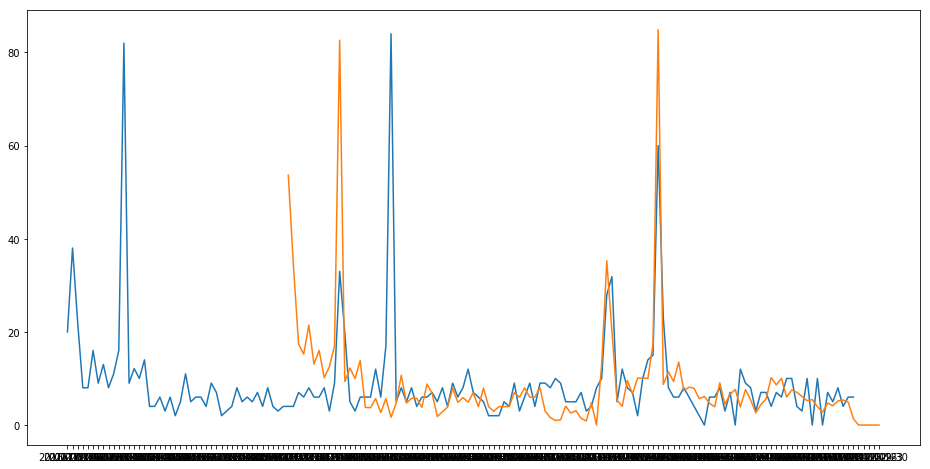

In [48]:
unique_items_grouped = data_tw.groupby(["product_rk","store_location_rk"],as_index=False)
unique_items_sizes = unique_items_grouped.count()[["product_rk","store_location_rk","period_start_dt"]]
unique_items_sizes = pd.DataFrame(unique_items_sizes).rename(columns={"period_start_dt":"days in table"})

full_data_pairs = unique_items_sizes[unique_items_sizes["days in table"]==unique_items_sizes["days in table"].max()]
full_data_pairs = full_data_pairs.reset_index()[["product_rk","store_location_rk"]]
print(full_data_pairs.shape)

def get_local_data(number):
    if number<0 or number>=full_data_pairs.shape[0]:
        raise Exception("numer out of array")
    product_rk,store_location_rk = full_data_pairs.loc[number]
    return data[(data["product_rk"] == product_rk)&(data["store_location_rk"]==store_location_rk)]

local_data = get_local_data(62)
plt.figure(figsize=(16,8))
plt.plot(local_data["period_start_dt"],local_data["demand"])
plt.plot(local_data["period_start_dt"], local_data["y_tw"])
plt.show()